In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import IntEnum, Enum

In [2]:
class Action(Enum):
  UP = 'U'
  DOWN = 'D'
  LEFT = 'L'
  RIGHT = 'R'

  def __str__(self):
    return str(self.value)

In [3]:
class State(IntEnum):
  ACCESSIBLE_GRID = 0
  INACCESSIBLE_GRID = -2
  LOSER_GRID = -1
  WINNER_GRID = 1

In [4]:
ACTION_SPACE = (Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT)
STATE_PROBS = [0.6, 0.35, 0.05] # prob of accessible grid, prob of inaccessible grid, prob of loser grid
STATES = [State.ACCESSIBLE_GRID, State.INACCESSIBLE_GRID, State.LOSER_GRID, State.WINNER_GRID]
UNKNOWN_POLICY = -2 # the policy is unknown for now, the policies are going to be determined after creating the gridworld
ROW_SIZE = 10
COLUMN_SIZE = 10
THRESHOLD = 1e-3
DISCOUNT_FACTOR = 0.9

In [5]:
class Gridworld: # Environment
  def __init__(self, rows, cols, start):
    self.rows = rows
    self.cols = cols
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_rewards(self, rewards):
    # rewards should be a dict of: (i, j): r (row, col): reward
    self.rewards = rewards

  def set_actions(self, actions):
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, state):
    return state not in self.actions

  def reset(self):
    # put agent back in start position
    self.i = ROW_SIZE - 1
    self.j = 0
    return (self.i, self.j)

  def get_next_state(self, state, action):
    # this answers: where would I end up if I perform action 'action' in state 's'?
    i, j = state[0], state[1]

    # if this action moves you somewhere else, then it will be in this dictionary
    if action == Action.UP:
      i -= 1
    elif action == Action.DOWN:
      i += 1
    elif action == Action.RIGHT:
      j += 1
    elif action == Action.LEFT:
      j -= 1

    return i, j

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == Action.UP:
        self.i -= 1
      elif action == Action.DOWN:
        self.i += 1
      elif action == Action.RIGHT:
        self.j += 1
      elif action == Action.LEFT:
        self.j -= 1
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == Action.UP:
      self.i += 1
    elif action == Action.DOWN:
      self.i -= 1
    elif action == Action.RIGHT:
      self.j -= 1
    elif action == Action.LEFT:
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())

In [6]:
def create_gridworld():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  gridworld = Gridworld(ROW_SIZE, COLUMN_SIZE, (ROW_SIZE, 0))

  rewards = {}
  actions = {}
  total_number_of_grids = ROW_SIZE * COLUMN_SIZE
  number_of_accessible_grid = int(total_number_of_grids * STATE_PROBS[State.ACCESSIBLE_GRID])
  number_of_inaccessible_grid = int(total_number_of_grids * STATE_PROBS[State.INACCESSIBLE_GRID])
  # We subtract the number of winner grid which is 1.
  number_of_loser_grid = total_number_of_grids - number_of_accessible_grid - number_of_inaccessible_grid - 1

  # populate the accessible grid
  num_grid = 0
  while num_grid < number_of_accessible_grid:
    i = np.random.choice(ROW_SIZE)
    j = np.random.choice(COLUMN_SIZE)
    state = (i, j)
    if state not in actions.keys():
      num_grid += 1
      actions[state] = None

  # populate the negative reward grid
  num_grid = 0
  while num_grid < number_of_loser_grid:
    i = np.random.choice(ROW_SIZE)
    j = np.random.choice(COLUMN_SIZE)
    state = (i, j)
    if state not in actions.keys() and state not in rewards.keys():
      num_grid += 1
      rewards[state] = -10

  # populate the positive reward grid
  num_grid = 0
  while num_grid < 1:
    i = np.random.choice(ROW_SIZE)
    j = np.random.choice(COLUMN_SIZE)
    state = (i, j)
    if state not in actions.keys() and state not in rewards.keys():
      num_grid += 1
      rewards[state] = 10

  gridworld.set_rewards(rewards)
  gridworld.set_actions(actions)

  # populate action space
  for key, _ in actions.items():
    actions_ = []
    for action in ACTION_SPACE:
      next_state = gridworld.get_next_state(state=key, action=action)
      if next_state in actions.keys() or next_state in rewards.keys():
        actions_.append(action)
    actions[key] = tuple(actions_)

  gridworld.set_actions(actions)
  return gridworld

In [7]:
def create_negative_gridworld(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  gridworld = create_gridworld()
  for key, _ in gridworld.actions:
    gridworld.rewards[key] = step_cost
  return gridworld

In [8]:
def print_values(value_function, gridworld):
  for i in range(gridworld.rows):
    print("---------------------------")
    for j in range(gridworld.cols):
      value = value_function.get((i,j), 0)
      if value >= 0:
        print(" %.2f|" % value, end="")
      else:
        print("%.2f|" % value, end="") # -ve sign takes up an extra space
    print("")

In [9]:
def print_policy(policy, gridworld):
  for i in range(gridworld.rows):
    print("---------------------------")
    for j in range(gridworld.cols):
      state = (i, j)
      action = policy.get(state, ' ')
      print("  %s  |" % action, end="")
    print("")

In [16]:
def play_game(gridworld, policy, max_steps=20):
  # We use "Exploring Starts" method
  start_states = list(gridworld.actions.keys())
  start_state = start_states[np.random.choice(len(start_states))]
  gridworld.set_state(start_state)

  state = gridworld.current_state()
  action = np.random.choice(ACTION_SPACE)

  states = [state]
  rewards = [0]
  actions = [action]

  steps = 0
  while steps < max_steps:
    reward = gridworld.move(action)
    next_state = gridworld.current_state()

    # update state and reward list
    states.append(next_state)
    rewards.append(reward)

    if not gridworld.game_over():
      action = policy[next_state]
      actions.append(action)
    else:
      break

    steps += 1
    state = next_state

  return states, actions, rewards

In [17]:
def max_dict(dict_):
  max_val = max(dict_.values())
  max_keys = [key for key, val in dict_.items() if val == max_val]
  return np.random.choice(max_keys), max_val

Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000


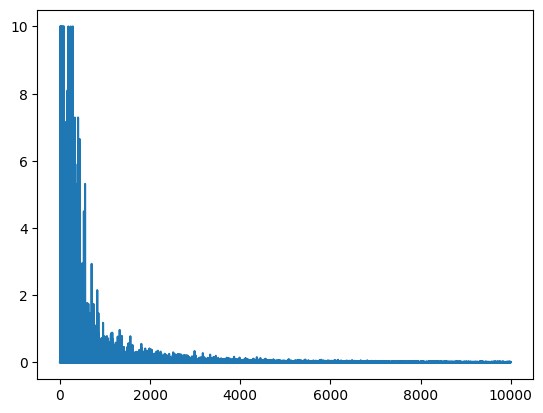

policy:
---------------------------
     |     |     |  D  |     |     |  R  |     |     |  D  |
---------------------------
  D  |  L  |     |     |  R  |  R  |  U  |     |  R  |  D  |
---------------------------
  D  |  L  |     |     |  R  |  R  |  U  |     |     |  D  |
---------------------------
  D  |     |  R  |  R  |  R  |  U  |  U  |  L  |  L  |  L  |
---------------------------
  R  |  D  |     |  U  |     |  U  |  U  |  U  |     |  U  |
---------------------------
     |  R  |  R  |  U  |     |     |     |     |     |  U  |
---------------------------
     |  U  |  R  |  U  |  L  |  L  |     |     |  R  |  U  |
---------------------------
  D  |     |  U  |     |     |  D  |     |  D  |     |     |
---------------------------
     |  R  |  U  |  L  |  L  |  L  |     |  U  |  L  |  L  |
---------------------------
     |  U  |     |  U  |     |  U  |  L  |     |     |  D  |

values MC:
---------------------------
 0.00| 0.00| 0.00| 0.00| 0.00| 0.00| 10.00| 0.00| 0.00| 3.85|


In [19]:
if __name__ == '__main__':

  gridworld = create_gridworld()

  # state -> action
  # we'll randomly choose an action and update as we learn
  policy = {}
  for state in gridworld.actions.keys():
    policy[state] = np.random.choice(ACTION_SPACE)

  q_table = {}
  sample_counts = {}
  states = gridworld.all_states()

  for state in states:
    if state in gridworld.actions:
      q_table[state] = {}
      sample_counts[state] = {}
      for action in ACTION_SPACE:
        q_table[state][action] = 0
        sample_counts[state][action] = 0

  deltas = []
  for it in range(10000):
    if it % 1000 == 0:
      print(f"Iteration: {it}")

    delta = 0
    states, actions, rewards = play_game(gridworld, policy)
    states_actions = list(zip(states, actions))

    return_ = 0
    rewards_ = rewards[1:]
    for t in range(len(states) - 2, -1, -1):
      reward = rewards[t + 1]
      return_ = reward + DISCOUNT_FACTOR * return_
      state = states[t]
      action = actions[t]

      # first-visit MC
      if (state, action) not in states_actions[:t]:
        old_q_value = q_table[state][action]
        sample_counts[state][action] += 1
        lr = 1 / sample_counts[state][action]
        q_table[state][action] = old_q_value + lr * (return_ - old_q_value)

        # update policy
        policy[state] = max_dict(q_table[state])[0]

        # update delta
        delta = max(delta, np.abs(q_table[state][action] - old_q_value))

    deltas.append(delta)

  plt.plot(deltas)
  plt.show();
  # once we're done, print the final policy and values
  print("policy:")
  print_policy(policy, gridworld)
  print()
  value_function_mc = {}
  for state, q_values in q_table.items():
    value_function_mc[state] = max_dict(q_table[state])[1]
  print("values MC:")
  print_values(value_function_mc, gridworld)
  print()
